In [1]:
import pandas as pd
import functions as func
import yaml
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import MinMaxScaler, StandardScaler

%matplotlib inline

db_locations = func.import_yaml()

#load df
df_train = pd.read_csv(db_locations['data_raw']['train'])
df_test = pd.read_csv(db_locations['data_raw']['test'])



Clean data

In [2]:
def update_fuel_type(df):
    df.loc[df['engine'].str.contains('Electric', case=False, na=False), 'fuel_type'] = 'Electric'
    df.loc[df['engine'].str.contains('Gasoline', case=False, na=False), 'fuel_type'] = 'Gasoline'
    df.loc[(df['brand'].str.lower() == 'tesla') & (df['engine'].str.contains('Dual Motor - Standard', case=False, na=False)), 'fuel_type'] = 'electric'
    
    return df

update_fuel_type(df_test)
update_fuel_type(df_train)



,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
0,0,MINI,Cooper S Base,2007,213000,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,Yellow,Gray,None reported,Yes,4200
1,1,Lincoln,LS V8,2002,143250,Gasoline,252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,A/T,Silver,Beige,At least 1 accident or damage reported,Yes,4999
2,2,Chevrolet,Silverado 2500 LT,2002,136731,E85 Flex Fuel,320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,A/T,Blue,Gray,None reported,Yes,13900
3,3,Genesis,G90 5.0 Ultimate,2017,19500,Gasoline,420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,Black,Black,None reported,Yes,45000
4,4,Mercedes-Benz,Metris Base,2021,7388,Gasoline,208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,7-Speed A/T,Black,Beige,None reported,Yes,97500
...,...,...,...,...,...,...,...,...,...,...,...,...,...
188528,188528,Cadillac,Escalade ESV Platinum,2017,49000,Gasoline,420.0HP 6.2L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,White,Beige,None reported,Yes,27500
188529,188529,Mercedes-Benz,AMG C 43 AMG C 43 4MATIC,2018,28600,Gasoline,385.0HP 3.0L V6 Cylinder Engine Gasoline Fuel,8-Speed A/T,White,Black,At least 1 accident or damage reported,Yes,30000
188530,188530,Mercedes-Benz,AMG GLC 63 Base 4MATIC,2021,13650,Gasoline,469.0HP 4.0L 8 Cylinder Engine Gasoline Fuel,7-Speed A/T,White,Black,None reported,Yes,86900
188531,188531,Audi,S5 3.0T Prestige,2022,13895,Gasoline,3.0L,1-Speed Automatic,Daytona Gray Pearl Effect,Black,None reported,NaN,84900


In [3]:
df_train['brand'].nunique()
df_train['model'].nunique()
# models are too numerous to be standardised, let's drop it

1897

Extract Engine

In [4]:
import re
# extract HP, Liters and Cylinder
def extract_engine_info(engine, fuel_type):
        hp_search = re.search(r'(\d+(\.\d+)?)HP', engine)
        litre_search = re.search(r'(\d+(\.\d+)?)L', engine)
        cylinders_search = re.search(r'(\d+) Cylinder', engine)
        
        hp = float(hp_search.group(1)) if hp_search else ''
        litres = float(litre_search.group(1)) if litre_search else ''
        cylinders = int(cylinders_search.group(1)) if cylinders_search else ''

        
        return pd.Series([hp, litres, cylinders])

engine_info = df_train.apply(lambda row: extract_engine_info(row['engine'], row['fuel_type']), axis=1)
df_train[['horsepower', 'engine_size', 'cylinders']] = engine_info

df_train.head()


,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price,horsepower,engine_size,cylinders
0,0,MINI,Cooper S Base,2007,213000,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,Yellow,Gray,None reported,Yes,4200,172.0,1.6,4.0
1,1,Lincoln,LS V8,2002,143250,Gasoline,252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,A/T,Silver,Beige,At least 1 accident or damage reported,Yes,4999,252.0,3.9,8.0
2,2,Chevrolet,Silverado 2500 LT,2002,136731,E85 Flex Fuel,320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,A/T,Blue,Gray,None reported,Yes,13900,320.0,5.3,8.0
3,3,Genesis,G90 5.0 Ultimate,2017,19500,Gasoline,420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,Black,Black,None reported,Yes,45000,420.0,5.0,8.0
4,4,Mercedes-Benz,Metris Base,2021,7388,Gasoline,208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,7-Speed A/T,Black,Beige,None reported,Yes,97500,208.0,2.0,4.0


Let's check the data

In [6]:
display(df_train['horsepower'].value_counts())
display(df_train['cylinders'].value_counts())
df_train['engine_size']TypeError: '<' not supported between instances of 'str' and 'float'

.value_counts().sort_index()
display(engine_size_value_counts)



SyntaxError: invalid syntax (2116007807.py, line 3)

In [5]:
# normalize the data
from sklearn.preprocessing import LabelEncoder

# scaler = StandardScaler()
# df_train[['horsepower_scaled', 'engine_size_scaled', 'cylinders_scaled']] = scaler.fit_transform(df_train[['horsepower', 'engine_size', 'cylinders']])
# df_train_encoded = pd.get_dummies(df_train, columns=['brand'])
le_brand = LabelEncoder()
df_train['brand_encoded'] = le_brand.fit_transform(df_train['brand'])

df_train['brand_encoded'].value_counts()
df_train['cylinders'].value_counts()



cylinders
6.0     63361
0.0     48585
8.0     46716
4.0     27215
12.0     1250
10.0      698
5.0       621
3.0        87
Name: count, dtype: int64

In [6]:
corr_matrix = df_train[['brand_encoded', 'model_year', 'cylinders', 'engine_size', 'price']].corr()
corr_matrix

,brand_encoded,model_year,cylinders,engine_size,price
brand_encoded,1.000000,-0.014605,-0.100625,-0.100927,0.017657
model_year,-0.014605,1.000000,-0.268743,-0.085152,0.231795
cylinders,-0.100625,-0.268743,1.000000,0.700138,-0.045158
engine_size,-0.100927,-0.085152,0.700138,1.000000,0.053913
price,0.017657,0.231795,-0.045158,0.053913,1.000000


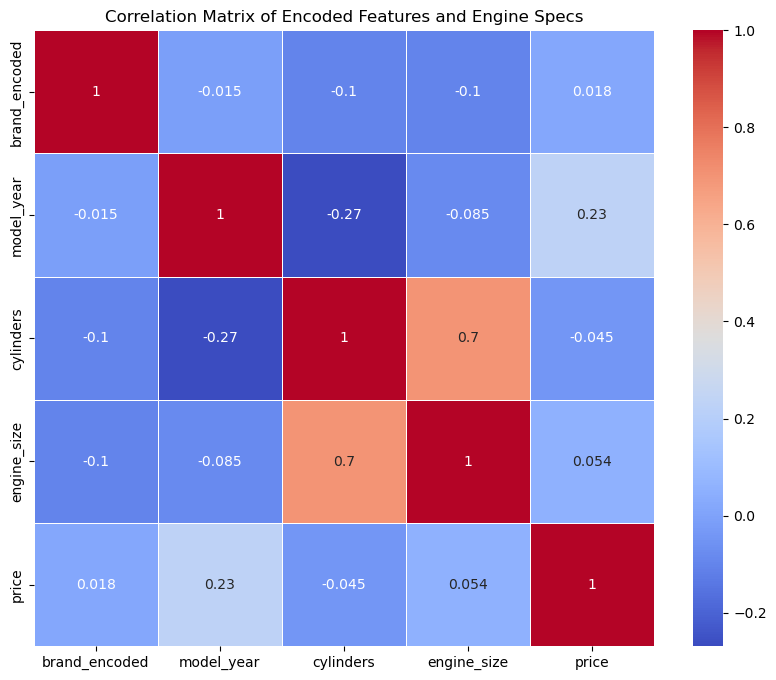

In [7]:
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix of Encoded Features and Engine Specs')
plt.show()

# analysis : HP,  Cylinder and engine_size have a very high correlation, we can drop one, horsepower is closer to targe,t let's keep it
# low correlation between brand, model or engine characteristics and price 
# engine_size is closer to price than HP, let's keep it
